# CNC專案 - CyberInsight幹嘛我們就幹嘛
- 富士康汇报5.18.pdf

In [21]:
%load_ext autoreload
%autoreload 2

import sys, os, datetime, pickle, warnings
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#中文字型
fp = matplotlib.font_manager.FontProperties(fname = 'font/NotoSansCJKtc-Regular.otf')
matplotlib.font_manager.fontManager.ttffiles.append(fp.get_file())
font_entry = matplotlib.font_manager.FontEntry(fp.get_file(), name=fp.get_name(),
                                               style=fp.get_style(), variant=fp.get_variant(),
                                              weight=fp.get_weight(), stretch=fp.get_stretch(), size=fp.get_size())

matplotlib.font_manager.fontManager.ttflist.append(font_entry)
plt.rcParams['font.family'] = fp.get_name()

from scipy.fftpack import fft, ifft
import pylab
import seaborn as sns
from nptdms import TdmsFile
import charts
from scipy.interpolate import spline
from scipy import signal
from scipy.signal import freqz, butter, lfilter
import datetime
from scipy.stats import skew, kurtosis
from sklearn import decomposition
import charts
from encodings.aliases import aliases

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
import xgboost as xgb
pd.set_option('display.width', 2000)

warnings.filterwarnings("ignore")



%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def df_dump(df, filename):
    path = open('cache/{f}'.format(f=filename), 'wb')
    print('dump',filename)
    return pickle.dump(df, path)
    
    
def df_load(filename):
    path = 'cache/{f}'.format(f=filename)
    if os.path.isfile(path):
        fh = open(path, 'rb')
        data = pickle.load(fh)
    else:
        data =None  
    print('load',filename)
    return data


In [3]:
# check the encoding
if False:
    for i in aliases.keys():
        try:
            testlog_df = pd.read_csv('data/GL/CS/KONG05/M03S0032813.csv', encoding=i)
            print(i)
            display(testlog_df.head(2))
        except:
            pass
            #print('error',i)


** read data functions **

In [4]:
def _readTDMSasDF(path):
    tdms_file = TdmsFile(path)
    tdms_df = tdms_file.as_dataframe()
    return tdms_df
def readTDMSasDF(path):
    tdms_file = TdmsFile(path)
    #tdms_df = tdms_file.as_dataframe()
    data_dict = {}
    time_dict= {}
    for p in tdms_file.objects.keys():
        path_list = list(filter(None, p.split('/')))
        path_list = list(map(lambda s: s.replace("'", ""), path_list ))
        if not path_list:
            continue
        if len(path_list)==1:
            continue
        if len(path_list)==2:
            obj=tdms_file.object(path_list[0],path_list[1])
            data = obj.data
            time = obj.time_track()
            data_dict['_'.join(path_list)] = data
            time_dict['_'.join(path_list)] = time
    return pd.DataFrame(data_dict, index = list(time_dict.values())[0])


## 刀具磨耗預測
###  - 數據切割
1. 按照控制器进给轴的位置数据，准确的切割出单一方向进给，匀速切削时的工况。后续特征提取建立在稳定可控的数据基础上。
 - 单一方向进给(把移動的拿掉)
 - 匀速切削

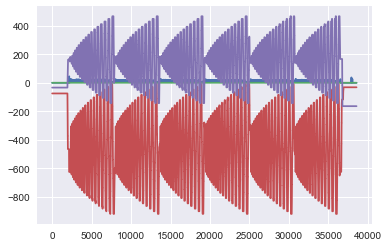

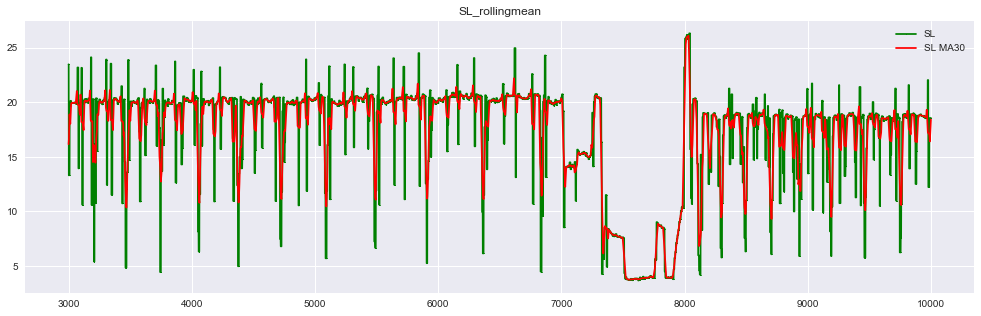

In [5]:
plc_df = pd.read_csv('data/GL/CS/KONG05/M03S0032813.csv', encoding='ms950')
plt.plot(plc_df['主軸負載'])
plt.plot(plc_df['切削量'])
plt.plot(plc_df['X軸機械座標'])
plt.plot(plc_df['Y軸機械座標'])
plt.show()

windowsize=25
plc_df['SL_rollingmean'] = plc_df['主軸負載'].rolling(window=windowsize, center=True).mean()
dataqty=10000
dummy = plt.figure(figsize=[17,5])
dummy = plt.plot( plc_df['主軸負載'][3000:dataqty],color='green',marker='o',ms=1,label='SL')
dummy = plt.plot( plc_df['SL_rollingmean'][3000:dataqty], color='red', ms=3,label='SL MA30')
plt.legend()
plt.title('SL_rollingmean')
plt.show()

2. 按照单次切削动作的时长，加上安全时间范围等间隔分割

### 特徵提取 - X

In [12]:
def getSensorData(folder_path):
    tdmsfilelist = []
    for f in os.listdir(folder_path):
        if not f.endswith('tdms'):
            continue
        else:
            tdmsfilelist.append(f)

    tdmsfilelist = sorted(tdmsfilelist)
    #print(tdmsfilelist)
    if True:
        df_list=[]
        for f in tdmsfilelist:
            try:
                path = '{}/{}'.format(folder_path, f)
                df_ = readTDMSasDF(path)
                tstr = f[5:-5]
                dtobj = datetime.datetime.strptime(tstr, '%y%m%d%H%M%S')
                df_['time'] = list(map(lambda x: x[0] + datetime.timedelta(0,x[1]), list(zip([dtobj]*len(df_.index), df_.index))))
                df_list.append(df_)
            except:
                print('except',path, os.path.getsize(path)/1024/1024)
                pass
    #print(len(df_list))
    tdms_df = pd.concat(df_list, ignore_index=True)
    return tdms_df


In [200]:
def fea_rms(d):
    return np.sqrt(np.square(d).mean())
    
def fea_peaktopeak(d):
    return (max(d) - min(d))

def fea_skewness(d):
    return skew(d)

def fea_kurtosis(d):
    return kurtosis(d)

def fea_x1tox10(d):
    pass

def fea_rpmorder(data,**kwargs):
    if len(data)==0:
        return None
    rpm, sr =kwargs['rpm'], kwargs['sr']
    #rpm=11000, sr=25600, rpmorder=1
    rmpHz = rpm/60
    fft_size = len(data)
    window = np.hanning(fft_size) 
    N = fft_size
    T = 1.0 /sr
    x = np.linspace(0.0, N*T, N)
    y = data
    y=y*window
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    xf_order = xf//rmpHz
    yf = 2.0/N * np.abs(yf[0:N//2])
    order1=yf[np.where(xf_order==1)[0].min()]
    order2=yf[np.where(xf_order==2)[0].min()]
    order3=yf[np.where(xf_order==3)[0].min()]
    order4=yf[np.where(xf_order==4)[0].min()]
    order5=yf[np.where(xf_order==5)[0].min()]
    order6=yf[np.where(xf_order==6)[0].min()]
    order7=yf[np.where(xf_order==7)[0].min()]
    order8=yf[np.where(xf_order==8)[0].min()]
    order9=yf[np.where(xf_order==9)[0].min()]
    order10=yf[np.where(xf_order==10)[0].min()]
    return (order1,order2,order3,order4,order5,order6,order7,order8,order9,order10)
    


In [240]:
fdlist = ['TEST0401', 'TEST0402', 'TEST0403', 'TEST0404','TEST0405','TEST0406','TEST0407','TEST0408','TEST0409','TEST0410','TEST0411','TEST0412','TEST0413']
feadf_list=[]
#fdlist = ['TEST0405','TEST0406','TEST0407','TEST0408','TEST0409','TEST0410','TEST0411','TEST0412','TEST0413']
rule='30s'
for f in fdlist:
    print(f)
    tdms_df=getSensorData(os.path.join('data/GL/CS/', f))
    tdms_df = tdms_df.sort_values(by='time')
    tdms_df = tdms_df.set_index('time')
    tdms_df = tdms_df[['Spindle_S01','Spindle_S02','Spindle_S03']]
   
    frms = tdms_df.resample(rule).apply(fea_rms)
    frms = frms.dropna()
    frms.rename(columns={'Spindle_S01': 'S01_RMS', 'Spindle_S02': 'S02_RMS','Spindle_S03':'S03_RMS'}, inplace=True)
    
    fp2p = tdms_df.resample(rule).apply(fea_peaktopeak)
    fp2p = fp2p.dropna()
    fp2p.rename(columns={'Spindle_S01': 'S01_P2P', 'Spindle_S02': 'S02_P2P','Spindle_S03':'S03_P2P'}, inplace=True)

    fskewness = tdms_df.resample(rule).apply(fea_skewness)
    fskewness = fskewness.dropna()
    fskewness.rename(columns={'Spindle_S01': 'S01_skewness', 'Spindle_S02': 'S02_skewness','Spindle_S03':'S03_skewness'}, inplace=True)

    fkurtosis = tdms_df.resample(rule).apply(fea_kurtosis)
    fkurtosis = fkurtosis.dropna()
    fkurtosis.rename(columns={'Spindle_S01': 'S01_kurtosis', 'Spindle_S02': 'S02_kurtosis','Spindle_S03':'S03_kurtosis'}, inplace=True)

    f3x = tdms_df.resample(rule).apply(fea_rpmorder, rpm=2000, sr=25600)
    f3x = f3x.dropna()
    f3x['S01_1x'] = f3x['Spindle_S01'].map(lambda x: x[0])
    f3x['S01_2x'] = f3x['Spindle_S01'].map(lambda x: x[1])
    f3x['S01_3x'] = f3x['Spindle_S01'].map(lambda x: x[2])
    f3x['S01_4x'] = f3x['Spindle_S01'].map(lambda x: x[3])
    f3x['S01_5x'] = f3x['Spindle_S01'].map(lambda x: x[4])
    f3x['S01_6x'] = f3x['Spindle_S01'].map(lambda x: x[5])
    f3x['S01_7x'] = f3x['Spindle_S01'].map(lambda x: x[6])
    f3x['S01_8x'] = f3x['Spindle_S01'].map(lambda x: x[7])
    f3x['S01_9x'] = f3x['Spindle_S01'].map(lambda x: x[8])
    f3x['S01_10x'] = f3x['Spindle_S01'].map(lambda x: x[9])

    f3x['S02_1x'] = f3x['Spindle_S02'].map(lambda x: x[0])
    f3x['S02_2x'] = f3x['Spindle_S02'].map(lambda x: x[1])
    f3x['S02_3x'] = f3x['Spindle_S02'].map(lambda x: x[2])
    f3x['S02_4x'] = f3x['Spindle_S02'].map(lambda x: x[3])
    f3x['S02_5x'] = f3x['Spindle_S02'].map(lambda x: x[4])
    f3x['S02_6x'] = f3x['Spindle_S02'].map(lambda x: x[5])
    f3x['S02_7x'] = f3x['Spindle_S02'].map(lambda x: x[6])
    f3x['S02_8x'] = f3x['Spindle_S02'].map(lambda x: x[7])
    f3x['S02_9x'] = f3x['Spindle_S02'].map(lambda x: x[8])
    f3x['S02_10x'] = f3x['Spindle_S02'].map(lambda x: x[9])

    f3x['S03_1x'] = f3x['Spindle_S03'].map(lambda x: x[0])
    f3x['S03_2x'] = f3x['Spindle_S03'].map(lambda x: x[1])
    f3x['S03_3x'] = f3x['Spindle_S03'].map(lambda x: x[2])
    f3x['S03_4x'] = f3x['Spindle_S03'].map(lambda x: x[3])
    f3x['S03_5x'] = f3x['Spindle_S03'].map(lambda x: x[4])
    f3x['S03_6x'] = f3x['Spindle_S03'].map(lambda x: x[5])
    f3x['S03_7x'] = f3x['Spindle_S03'].map(lambda x: x[6])
    f3x['S03_8x'] = f3x['Spindle_S03'].map(lambda x: x[7])
    f3x['S03_9x'] = f3x['Spindle_S03'].map(lambda x: x[8])
    f3x['S03_10x'] = f3x['Spindle_S03'].map(lambda x: x[9])
    f3x = f3x.drop('Spindle_S01', axis=1)
    f3x = f3x.drop('Spindle_S02', axis=1)
    f3x = f3x.drop('Spindle_S03', axis=1)
    
    tdms_features = pd.concat([frms, fp2p, fskewness, fkurtosis, f3x], axis=1)
    feadf_list.append(tdms_features)
    del tdms_df

X_df = pd.concat(feadf_list, ignore_index=True)




TEST0405
TEST0406
TEST0407
TEST0408
TEST0409
TEST0410
except data/GL/CS/TEST0410/test4180502200101.tdms 70.92636203765869
except data/GL/CS/TEST0410/test4180502200301.tdms 70.92636203765869
except data/GL/CS/TEST0410/test4180502201103.tdms 70.92636203765869
TEST0411
TEST0412
TEST0413


In [263]:
df_dump(X_df, 'glcs04.pkl')

dump glcs04.pkl


### 磨耗量 Y

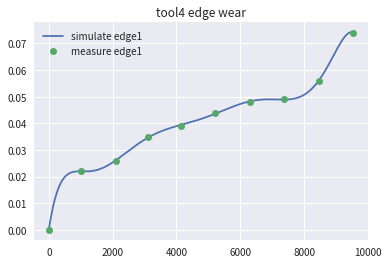

In [256]:
meaturetime=[0, 17 ,18, 17, 17, 18, 18, 18,18,18]
nPoint= X_df.shape[0]
y_flank1 =np.array([0 ,0.14 ,0.196 ,0.214 ,0.227 ,0.256 ,0.266 ,0.267 ,0.483 ,1.566])
y_edge1 =np.array([0, 0.022 ,0.026 ,0.035 ,0.039 ,0.044 ,0.048 ,0.049 ,0.056 ,0.074])

acumT=0
X_timesec = []
for i in meaturetime:
    acumT=acumT+i*60
    X_timesec.append(acumT)
X_timesec = np.array(X_timesec)
X_timesec = X_timesec.reshape(X_timesec.shape[0], 1)

X_simulate = np.linspace(0,X_timesec.flatten().max(),nPoint)
X_simulate = X_simulate.reshape(X_simulate.shape[0], 1)
model = make_pipeline(PolynomialFeatures(8), Ridge())
model.fit(X_timesec, y_edge1)
y_simulate1 = model.predict(X_simulate)

plt.plot(X_simulate, y_simulate1, label='simulate edge1')
plt.plot(X_timesec, y_edge1, 'o', label='measure edge1')
plt.title('tool4 edge wear')
plt.legend()

### 刀具磨損量預測模型

In [257]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())
def me(predictions, targets):
    return (predictions - targets).mean()
def mae(predictions, targets):
    return np.abs((predictions - targets)).mean()
def maxae(predictions, targets):
    return np.abs((predictions - targets)).max()
def minae(predictions, targets):
    return np.abs((predictions - targets)).min()

**一半的資料訓練, 一半的資料測試**  
**用X(t-2)預測y(t)**  

In [298]:
train_x = X_df.shift(2)[2::2]
test_x = X_df.shift(2)[3::][::2]
train_y = y_simulate1[2::2]
#test_y = y_simulate1[1::][::2]

xgbr1 = xgb.XGBRegressor(max_depth=4, n_estimators=300, learning_rate=0.05).fit(train_x.fillna(0), train_y)
y_predTra = xgbr1.predict(train_x.fillna(0))
y_predTes = xgbr1.predict(test_x.fillna(0))

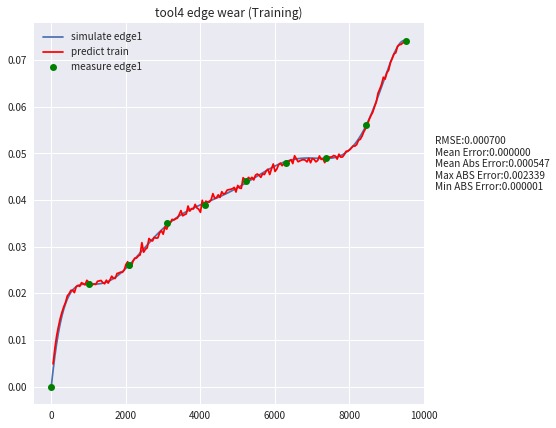

In [300]:
plt.figure(figsize=(7,7))
plt.plot(X_simulate, y_simulate1, label='simulate edge1')
plt.plot(X_simulate[2::2], y_predTra,'r', label='predict train')
plt.plot(X_timesec, y_edge1, 'go',label='measure edge1')

plt.title('tool4 edge wear (Training)')
plt.legend()
msg = 'RMSE:{}\nMean Error:{}\nMean Abs Error:{}\nMax ABS Error:{}\nMin ABS Error:{}'.format('%2f'%rmse(y_pred1, y_simulate1), '%2f'%me(y_pred1, y_simulate1), '%2f'%mae(y_pred1, y_simulate1), '%2f'%maxae(y_pred1, y_simulate1), '%2f'%minae(y_pred1, y_simulate1))
plt.text(10300,np.median(y_pred1), msg)
plt.show()

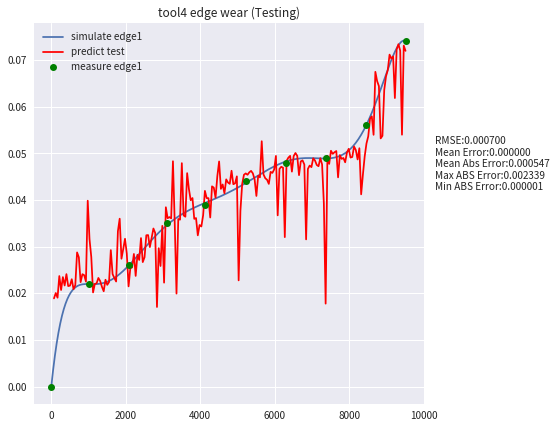

In [301]:
plt.figure(figsize=(7,7))
plt.plot(X_simulate, y_simulate1, label='simulate edge1')
plt.plot(X_simulate[3::][::2],y_predTes, 'r', label='predict test')
plt.plot(X_timesec, y_edge1, 'go',label='measure edge1')

plt.title('tool4 edge wear (Testing)')
plt.legend()
msg = 'RMSE:{}\nMean Error:{}\nMean Abs Error:{}\nMax ABS Error:{}\nMin ABS Error:{}'.format('%2f'%rmse(y_pred1, y_simulate1), '%2f'%me(y_pred1, y_simulate1), '%2f'%mae(y_pred1, y_simulate1), '%2f'%maxae(y_pred1, y_simulate1), '%2f'%minae(y_pred1, y_simulate1))
plt.text(10300,np.median(y_pred1), msg)
plt.show()

**用全部的資料訓練, 全部的資料測試**

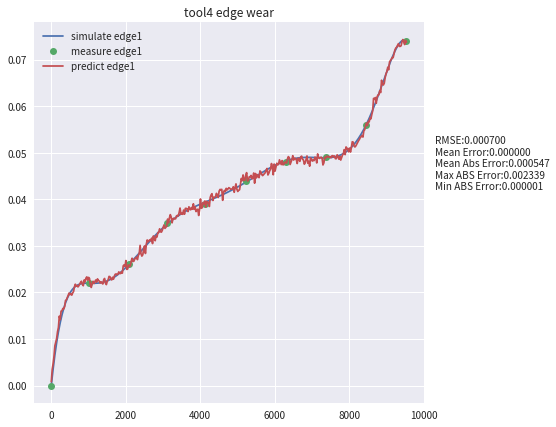

In [262]:
plt.figure(figsize=(7,7))
plt.plot(X_simulate, y_simulate1, label='simulate edge1')
plt.plot(X_timesec, y_edge1, 'o',label='measure edge1')
plt.plot(X_simulate, y_pred1, label='predict edge1')
#plt.axhline(y_simulate1.mean())
#plt.axhline(y_edge1.mean())

plt.title('tool4 edge wear')
plt.legend()
msg = 'RMSE:{}\nMean Error:{}\nMean Abs Error:{}\nMax ABS Error:{}\nMin ABS Error:{}'.format('%2f'%rmse(y_pred1, y_simulate1), '%2f'%me(y_pred1, y_simulate1), '%2f'%mae(y_pred1, y_simulate1), '%2f'%maxae(y_pred1, y_simulate1), '%2f'%minae(y_pred1, y_simulate1))
plt.text(10300,np.median(y_pred1), msg)
plt.show()

***

## 主轴故障引入实验数据分析

### 數據切割 - Stationary Data

In [348]:
def getPLCData(filepath, datestr):
    plc_df = pd.read_csv(filepath)
    plc_df['Time(ms)'] = plc_df['Time(ms)'].map(lambda s: s.strip())
    print(plc_df.shape)
    plc_df['Time(ms)']=plc_df['Time(ms)'].map(lambda x: datestr+' '+x)
    plc_df['Time(ms)']=pd.to_datetime(plc_df['Time(ms)'], format="%Y%m%d %H:%M:%S:%f") #13:43:42:550
    plc_df = plc_df.set_index('Time(ms)')
    plc_df = plc_df.apply(pd.to_numeric, errors='ignore')
    plc_df = plc_df.fillna(0)
    return plc_df

def getSensorData(folder_path):
    tdmsfilelist = []
    for f in os.listdir(folder_path):
        if not f.endswith('tdms'):
            continue
        else:
            tdmsfilelist.append(f)

    tdmsfilelist = sorted(tdmsfilelist)
    if True:
        df_list=[]
        for f in tdmsfilelist:
            try:
                path = os.path.join(folder_path, f)
                #path = '{}/{}'.format(folder_path, f)
                df_ = readTDMSasDF(path)
                tstr = f[-17:-5]
                dtobj = datetime.datetime.strptime(tstr, '%y%m%d%H%M%S')
                df_['time'] = list(map(lambda x: x[0] + datetime.timedelta(0,x[1]), list(zip([dtobj]*len(df_.index), df_.index))))
                df_list.append(df_)
            except:
                #print('except',path, os.path.getsize(path)/1024/1024)
                pass
    #print(len(df_list))
    tdms_df = pd.concat(df_list, ignore_index=True)
    return tdms_df

def getStationaryData(plc_df, sensordata, speed):
    dur = plc_df[plc_df['spindle command S(rpm)']==speed].index
    endtime = max(dur)
    dur = plc_df[plc_df['spindle real S(rpm)']>=speed].index
    starttime = min(dur)
    print(speed, starttime, endtime)
    tdata = sensordata[(sensordata['time']>=starttime) & (sensordata['time']<=endtime)]
    print(tdata.shape)
    return tdata

if True:
    plc_df_0515G=getPLCData('data/GL/FCFT_0515/FCFT-20180515/PLC/20180515_140458.csv', '20180515')
    plc_df_0515B=getPLCData('data/GL/FCFT_0515/FCFT-20180515DUIBI3.1/PLC/20180515_150559.csv', '20180515')
    tdms_df_0515G=getSensorData('data/GL/FCFT_0515/FCFT-20180515/')     
    tdms_df_0515B=getSensorData('data/GL/FCFT_0515/FCFT-20180515DUIBI3.1/')   
    stationary_17k_df_G = getStationaryData(plc_df_0515G, tdms_df_0515G, 17000)
    stationary_17k_df_B = getStationaryData(plc_df_0515B, tdms_df_0515B, 17000)
    stationary_17k_df = pd.concat([stationary_17k_df_G, stationary_17k_df_B], ignore_index=True)    
    stationary_17k_df['speed'] = 17000
    del tdms_df_0515G
    del tdms_df_0515B
    #stationary_17k_df = stationary_17k_df.reset_index()
    stationary_17k_df = stationary_17k_df.set_index('time')
    stationary_17k_df = stationary_17k_df[['Spindle_S01','Spindle_S02','Spindle_S03']]


(52401, 15)
(51591, 15)
17000 2018-05-15 14:13:24.571000 2018-05-15 14:14:36.496000
(1841280, 7)
17000 2018-05-15 15:14:24.625000 2018-05-15 15:15:25.126000
(1536026, 7)


** 1x feature extraction **

In [418]:
def fea_rpmorder(data,**kwargs):
    if len(data)==0:
        return None
    rpm, sr, rpmorder=kwargs['rpm'], kwargs['sr'], kwargs['rpmorder']
    #rpm=11000, sr=25600, rpmorder=1
    rmpHz = rpm/60
    fft_size = len(data)
    window = np.hanning(fft_size) 
    N = fft_size
    T = 1.0 /sr
    x = np.linspace(0.0, N*T, N)
    y = data
    y=y*window
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    xf_order = xf//rmpHz
    yf = 2.0/N * np.abs(yf[0:N//2])
    return yf[np.where(xf_order==rpmorder)[0].min()]


In [379]:

stationary_17k_1x = stationary_17k_df.resample('5s').apply(fea_rpmorder, rpm=17000, sr=25600, rpmorder=1)
stationary_17k_1x.rename(columns={'Spindle_S01': 'S01_1x', 'Spindle_S02': 'S02_1x','Spindle_S03':'S03_1x'}, inplace=True)
stationary_17k_1x= stationary_17k_1x.dropna()




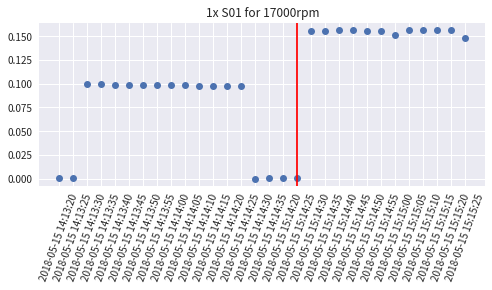

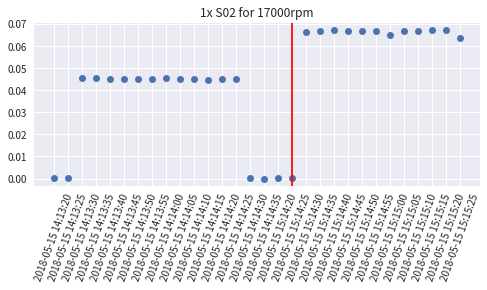

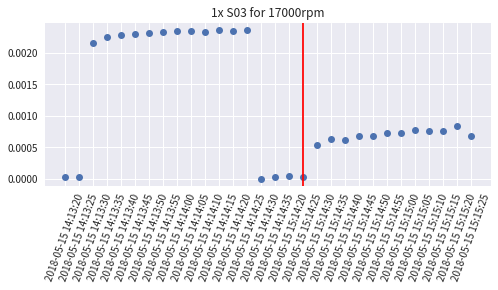

In [430]:
plt.figure(figsize=(8,3))
plt.plot(stationary_17k_1x['S01_1x'].values,'o')
plt.xticks(range(30), list(map(lambda x: str(x), list(stationary_17k_1x.index))), rotation=70)
plt.axvline(17,0,1, color='r')
plt.title('1x S01 for 17000rpm')
plt.show()


plt.figure(figsize=(8,3))
plt.plot(stationary_17k_1x['S02_1x'].values,'o')
plt.xticks(range(30), list(map(lambda x: str(x), list(stationary_17k_1x.index))), rotation=70)
plt.axvline(17,0,1, color='r')
plt.title('1x S02 for 17000rpm')
plt.show()

plt.figure(figsize=(8,3))
plt.plot(stationary_17k_1x['S03_1x'].values,'o')
plt.xticks(range(30), list(map(lambda x: str(x), list(stationary_17k_1x.index))), rotation=70)
plt.axvline(17,0,1, color='r')
plt.title('1x S03 for 17000rpm')
plt.show()

** RMS feature extraction**

In [419]:

def fea_rms(d):
    return np.sqrt(np.square(d).mean())

stationary_17k_rms = stationary_17k_df.resample('5s').apply(fea_rms)
stationary_17k_rms.rename(columns={'Spindle_S01': 'S01_rms', 'Spindle_S02': 'S02_rms','Spindle_S03':'S03_rms'}, inplace=True)
stationary_17k_rms= stationary_17k_rms.dropna()



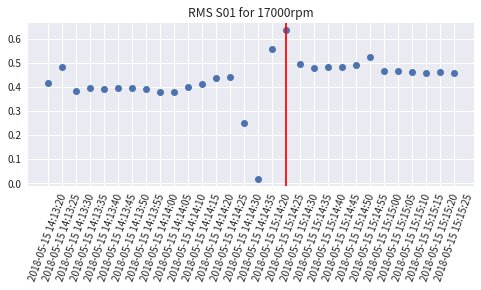

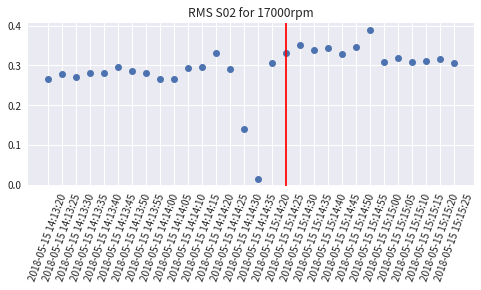

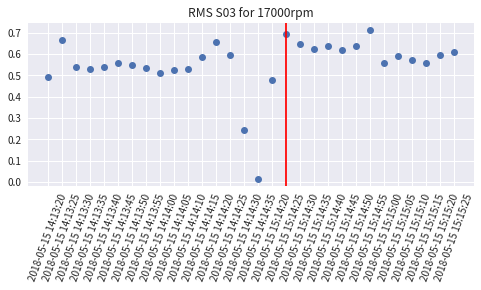

In [429]:
plt.figure(figsize=(8,3))
plt.plot(stationary_17k_rms['S01_rms'].values,'o')
plt.xticks(range(30), list(map(lambda x: str(x), list(stationary_17k_rms.index))), rotation=70)
plt.axvline(17,0,1, color='r')
plt.title('RMS S01 for 17000rpm')
plt.show()


plt.figure(figsize=(8,3))
plt.plot(stationary_17k_rms['S02_rms'].values,'o')
plt.xticks(range(30), list(map(lambda x: str(x), list(stationary_17k_rms.index))), rotation=70)
plt.axvline(17,0,1, color='r')
plt.title('RMS S02 for 17000rpm')
plt.show()

plt.figure(figsize=(8,3))
plt.plot(stationary_17k_rms['S03_rms'].values,'o')
plt.xticks(range(30), list(map(lambda x: str(x), list(stationary_17k_rms.index))), rotation=70)
plt.axvline(17,0,1, color='r')
plt.title('RMS S03 for 17000rpm')
plt.show()